In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../include/")
import hhtools

import importlib
importlib.reload(hhtools)

<module 'hhtools' from '/home/jungyoung/Project/hh_neuralnet/three_pop_mpi/../include/hhtools.py'>

# Check summary 

In [94]:
obj = hhtools.SummaryLoader("./asym_link/", num_overlap=2)
print(obj.summary["chi"].shape)
print(obj.controls.keys())

(13, 13, 2, 6, 2, 2, 3)
dict_keys(['alpha_set', 'beta_set', 'id_rank', 'p_ratio_set'])


In [121]:
def get_sub_summary(nid_rank, np_ratio_set):
    sz = list(obj.summary["chi"].shape[:2])
    keys = ["chi", "frs_m", "cv"]
    summary_sub = {k: np.zeros(sz+[3]) for k in keys}

    num_itr = obj.summary["chi"].shape[-3]
    num_overlap = obj.summary["chi"].shape[-2]

    for k in keys:
        for i in range(num_itr):
            for j in range(num_overlap):
                summary_sub[k] += obj.summary[k][:,:,nid_rank, np_ratio_set,i,j,:]
        summary_sub[k] /= num_itr*num_overlap
        
    return summary_sub

def show_summary(nid_pop, vmaxs=None, vmins=None):
    if vmaxs is None:
        vmaxs = [None] * 3
    if vmins is None:
        vmins = [None] * 3
    
    plt.figure(dpi=120, figsize=(11, 3.5))
    for n, k in enumerate(keys):
        plt.subplot(1,3,n+1)
        hhtools.imshow_xy(summary_sub[k][:,:,nid_pop], x=x, y=y, cmap="jet", vmin=vmins[n], vmax=vmaxs[n])
        plt.colorbar()
        plt.title(titles[n], fontsize=14)
        plt.xlabel(r"$\beta$", fontsize=15)
        plt.ylabel(r"$\alpha$", fontsize=15)
    
    w = obj.controls["p_ratio_set"][np_ratio_set]
    plt.suptitle(titles_summary[nid_pop] + " (w=%.2f)"%(w), fontsize=14)
    plt.tight_layout()
    plt.show()

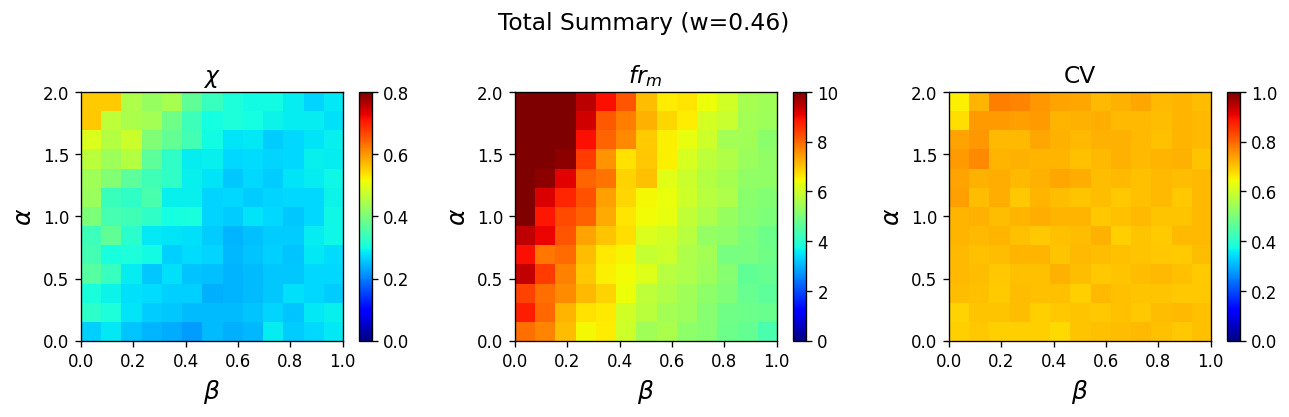

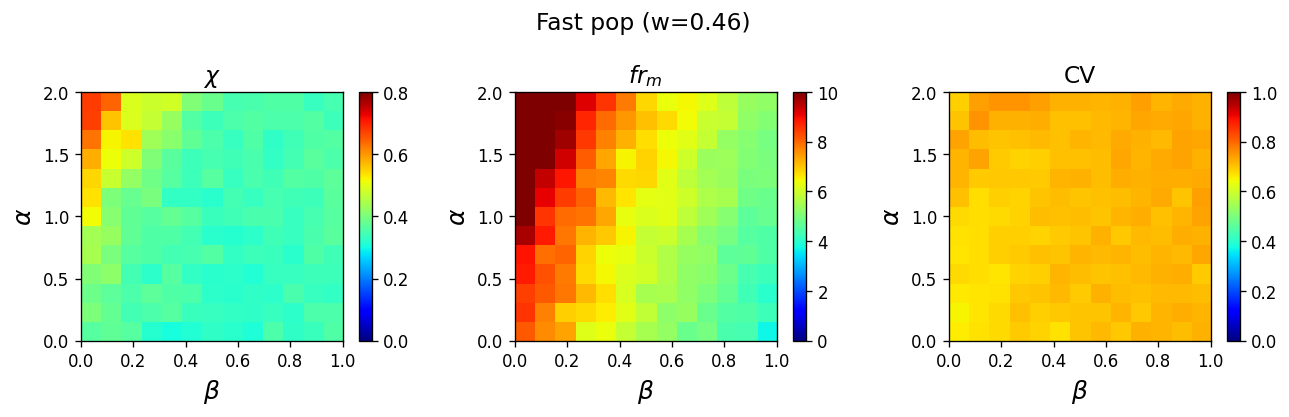

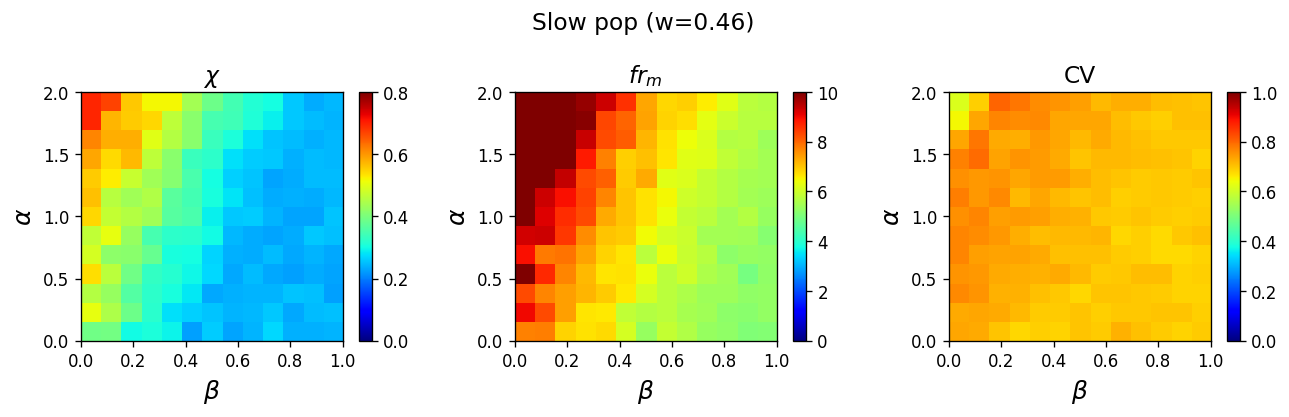

In [199]:
x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]
titles = [r"$\chi$", r"$fr_m$", r"CV"]
titles_summary = ["Total Summary", "Fast pop", "Slow pop"]

nid_rank = 1
np_ratio_set = 2

summary_sub = get_sub_summary(nid_rank, np_ratio_set)


show_summary(0, vmins=(0, 0, 0), vmaxs=(0.8, 10, 1))
show_summary(1, vmins=(0, 0, 0), vmaxs=(0.8, 10, 1))
show_summary(2, vmins=(0, 0, 0), vmaxs=(0.8, 10, 1))

# Cross-correlation 

## Find 2nd peak of auto correlation 

In [31]:
from scipy.signal import correlate


def get_correlation(x, y, max_pad=None):
    xn = x - np.average(x)
    yn = y - np.average(y)
    std = [np.std(xn), np.std(yn)]

    if max_pad is None:
        max_pad = len(x)

    if (std[0] == 0) or (std[1] == 0):  
        return np.zeros(2*max_pad+1)
    
    pad = np.zeros(int(max_pad))
    xn = np.concatenate((pad, x, pad))
    
    # return np.correlate(xn, yn, mode="valid")/len(xn)/std[0]/std[1]
    return correlate(xn, yn, mode="valid", method="fft")/len(xn)/std[0]/std[1]


def get_lfp_correlation(lfp1, lfp2, tlag_max=0.5, fs=2000):
    max_pad = int(tlag_max * fs)
    cc = get_correlation(lfp1, lfp2, max_pad=max_pad)
    
    num_cc = len(cc)//2
    tlag = np.arange(-num_cc, num_cc+1) / fs
    return cc, tlag

In [165]:
def find_corr_peaks(c, prominence=0.05):
    from scipy.signal import find_peaks
    
    ind_peaks, _ = find_peaks(c, prominence=prominence)
    n0 = len(c)//2
    
    # sort them with distance from zero-point
    dn = np.abs(ind_peaks - n0)
    ind = np.argsort(dn)
    return ind_peaks[ind[:3]]


def get_auto_2nd_peak(lfp, tlag_max=0.5, fs=2000):
    cc, tlag = get_lfp_correlation(lfp, lfp, tlag_max=tlag_max, fs=fs)
    id_peaks = find_corr_peaks(cc, tlag)
    return cc[id_peaks[1]]

In [200]:
from tqdm.notebook import tqdm

nid_rank = 1
np_ratio_set = 2
nitr = 0

sz = obj.summary["chi"].shape

t_peak2 = [np.zeros(sz[:2]), np.zeros(sz[:2]), np.zeros(sz[:2])] 

num_t = 5
for i in tqdm(range(sz[0])):
    for j in range(sz[1]):
        data = obj.load_detail(i, j, nid_rank, np_ratio_set, nitr)
        
        idt = data["ts"] >= 0.3
        for k in range(3):
            x = data["vlfp"][k][idt]
            t_peak2[k][i, j] = get_auto_2nd_peak(x, tlag_max=0.1)
        
#         # peak randomized starting times
#         for k in range(num_t):
#             t0 = np.random.rand()*1.5 + 0.3
#             idt = (data["ts"] >= t0) & (data["ts"] < t0+1)
            
#             x = data["vlfp"][1][idt]
#             t_peak2[0][i, j] += get_auto_2nd_peak(x, tlag_max=0.1)/num_t
            
#             x = data["vlfp"][2][idt]
#             t_peak2[1][i, j] += get_auto_2nd_peak(x, tlag_max=0.1)/num_t
            

  0%|          | 0/13 [00:00<?, ?it/s]

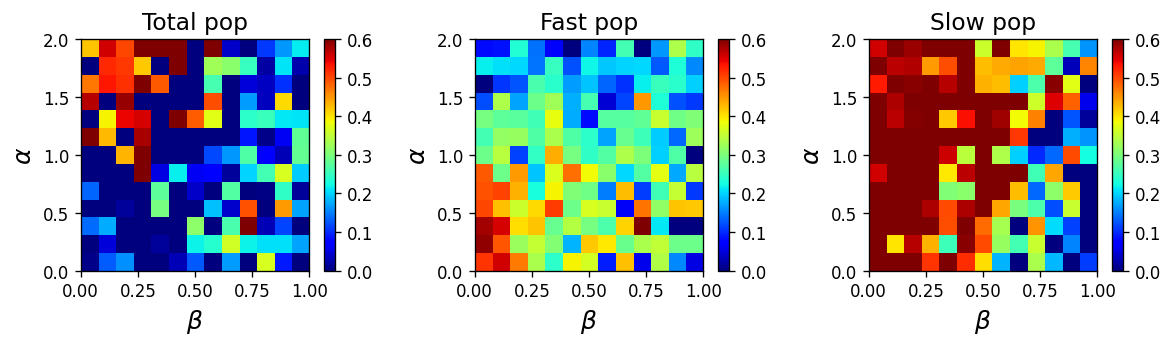

In [209]:
x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]
titles_summary = ["Total pop", "Fast pop", "Slow pop"]

plt.figure(dpi=120, figsize=(10, 3))
for n in range(3):
    plt.subplot(1,3,n+1)
    hhtools.imshow_xy(t_peak2[n], x=x, y=y, cmap="jet", vmin=0, vmax=0.6, interpolation="none")
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)
    plt.title(titles_summary[n], fontsize=14)
    
    plt.colorbar()
plt.tight_layout()

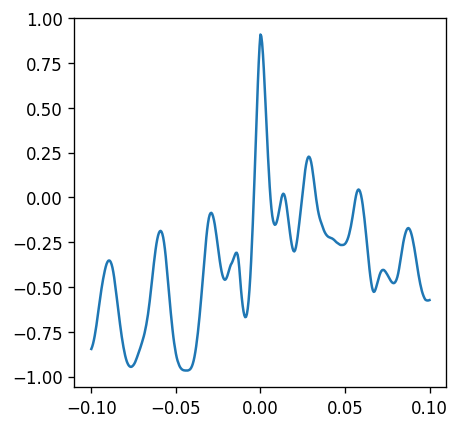

In [203]:
data = obj.load_detail(1, 1, nid_rank, np_ratio_set, 0)

cc, tlag = get_lfp_correlation(data["vlfp"][0], data["vlfp"][0], tlag_max=0.1)

plt.figure(dpi=120, figsize=(4,4))
plt.plot(tlag, cc)
plt.show()

## Check each sample 

In [ ]:
nid_row = [1, 10, 10, 1]
nid_col = [1, 1, 10, 10]

nn = 0

x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]
data = obj.load_detail(nid_row[nn], nid_col[nn], nid_rank, np_ratio_set, nitr)
lb  = r"$\alpha$=%.2f, $\beta$=%.2f"%(y[nid_row[nn]], x[nid_col[nn]])

plt.figure(dpi=120, figsize=(9, 2))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(1500, 2000))
plt.ylabel(lb, fontsize=14)
plt.xlabel("time (ms)", fontsize=14)
plt.show()

plt.figure(dpi=120, figsize=(9, 3))
nset = [[1, 1], [2, 2], [1, 2]]
lbs = ["CC(F, F)", "CC(S, S)", "CC(F, S)"]

for n in range(3):
    cc, tlag = get_lfp_correlation(data["vlfp"][nset[n][0]], data["vlfp"][nset[n][1]], tlag_max=0.05)
    
    plt.subplot(1,3,n+1)
    plt.plot(tlag*1e3, cc)
    plt.xlim([-50, 50])
    yl = plt.ylim()
    plt.plot([0, 0], yl, 'k--', lw=1)
    plt.ylim(yl)
    plt.ylabel(lbs[n], fontsize=14)
    plt.xlabel(r"$t_{lag}$ (ms)", fontsize=14)
plt.suptitle(lb, fontsize=14)
    
plt.tight_layout()
plt.show()

In [ ]:
print("A")

In [155]:
cc, tlag = get_lfp_correlation(data["vlfp"][1], data["vlfp"][1], tlag_max=0.1)

0.9090800692487778
0.404057082542631
0.5210494760827992


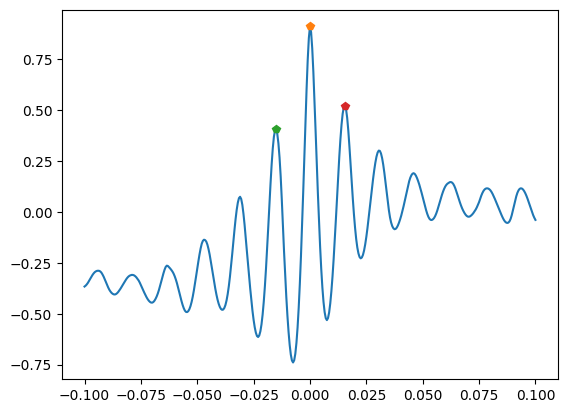

In [157]:
ind_peaks = find_corr_peaks(cc)

plt.figure()
plt.plot(tlag, cc)
for n in ind_peaks:
    plt.plot(tlag[n], cc[n], 'p')
    print(cc[n])
plt.show()

## Check auto-correlation 

In [58]:
data = obj.load_detail(14, 1, 2, 0, 0)
cc, tlag = get_lfp_correlation(data["vlfp"][1], data["vlfp"][2], tlag_max=0.1)

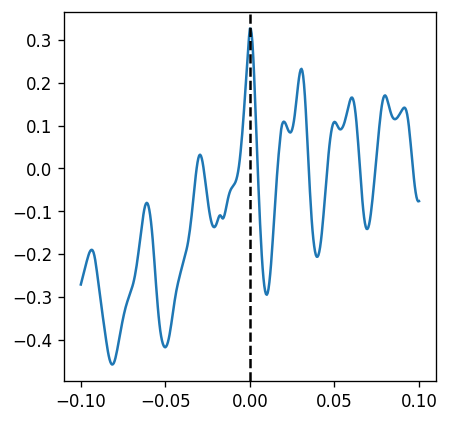

0.0


In [59]:
plt.figure(dpi=120, figsize=(4,4))
plt.plot(tlag, cc)
t_cc = tlag[np.argmax(cc)]

yl = plt.ylim()
plt.plot([t_cc]*2, yl, 'k--')
plt.ylim(yl)

plt.show()

print(t_cc)

In [ ]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 150), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

## Raster plot 

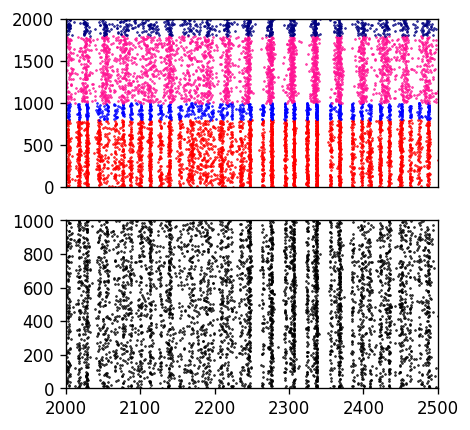

In [57]:
data = obj.load_detail(14, 1, 2, 0, 0)

plt.figure(dpi=120, figsize=(4, 4))
plt.subplot(211)
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2000, 2500))
plt.xticks([])

plt.subplot(212)
nid = np.random.choice(np.arange(2000), size=1000, replace=False)
step_tmp = []
for n in nid:
    step_tmp.append(data["step_spk"][n])
hhtools.draw_spk(step_tmp, color_ranges=None, xl=(2000, 2500))

plt.show()